In [5]:
import random
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import librosa

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings(action='ignore')

In [11]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # Melspectrogram 벡터를 추출할 개수
    'SEED':42
}

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [8]:
train_df = pd.read_csv('./open/train.csv')
test_df = pd.read_csv('./open/test.csv')

train_df['path'] = train_df['path'].str[2:]
test_df['path'] = test_df['path'].str[2:]

train_df['path'] = './open/' + train_df['path']
test_df['path'] = './open/' + test_df['path']

In [12]:
def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['path']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)

    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    return mfcc_df

In [13]:
train_x = get_mfcc_feature(train_df)
test_x = get_mfcc_feature(test_df)

100%|██████████| 1881/1881 [00:16<00:00, 115.89it/s]


In [14]:
train_y = train_df['label']

In [22]:
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, train_size=.8, random_state=CFG['SEED'], stratify=train_y)

In [23]:
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)
print(test_x.shape)

(4000, 128) (1001, 128)
(4000,) (1001,)
(1881, 128)


In [30]:
x_train_np = np.array(x_train).reshape(4000,128,1)
x_val_np = np.array(x_val).reshape(1001,128,1)
x_test_np = np.array(test_x).reshape(1881,128,1)

In [32]:
model = Sequential()
model.add(layers.LSTM(128, 
                      kernel_regularizer=keras.regularizers.l2(.01),
                      input_shape=(None, 1)))
model.add(layers.Dropout(.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6, activation='softmax'))

In [33]:
model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=["acc"]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 67,846
Trainable params: 67,590
Non-trainable params: 256
_________________________________________________________________


In [34]:
hist = model.fit(
    x_train_np, y_train, validation_data=(x_val_np, y_val), batch_size=128, epochs=50
)

Epoch 1/50
32/32 [==============================] - 7s 149ms/step - loss: 1.8564 - acc: 0.1807 - val_loss: 1.8024 - val_acc: 0.1698
Epoch 2/50
32/32 [==============================] - 5s 141ms/step - loss: 1.8162 - acc: 0.1855 - val_loss: 1.7973 - val_acc: 0.1698
Epoch 3/50
32/32 [==============================] - 5s 141ms/step - loss: 1.8138 - acc: 0.1760 - val_loss: 1.7950 - val_acc: 0.1738
Epoch 4/50
32/32 [==============================] - 5s 143ms/step - loss: 1.8089 - acc: 0.1838 - val_loss: 1.7938 - val_acc: 0.1728
Epoch 5/50
32/32 [==============================] - 4s 140ms/step - loss: 1.8058 - acc: 0.1828 - val_loss: 1.7933 - val_acc: 0.1908
Epoch 6/50
32/32 [==============================] - 4s 139ms/step - loss: 1.8021 - acc: 0.1813 - val_loss: 1.7924 - val_acc: 0.1778
Epoch 7/50
32/32 [==============================] - 4s 139ms/step - loss: 1.7978 - acc: 0.1835 - val_loss: 1.7923 - val_acc: 0.1838
Epoch 8/50
32/32 [==============================] - 4s 139ms/step - loss: 1.

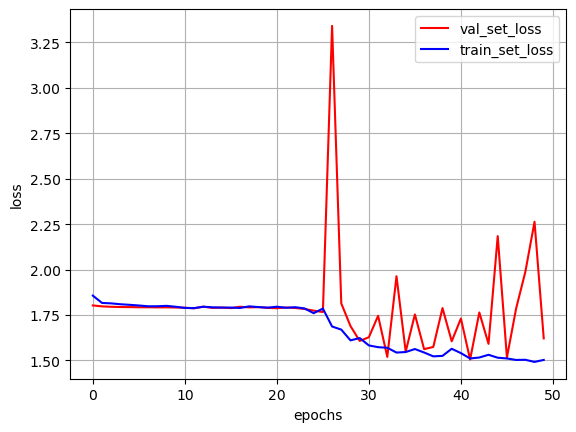

In [36]:
import matplotlib.pyplot as plt

y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len,y_vloss,c='red',label='val_set_loss')
plt.plot(x_len,y_loss,c='blue',label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

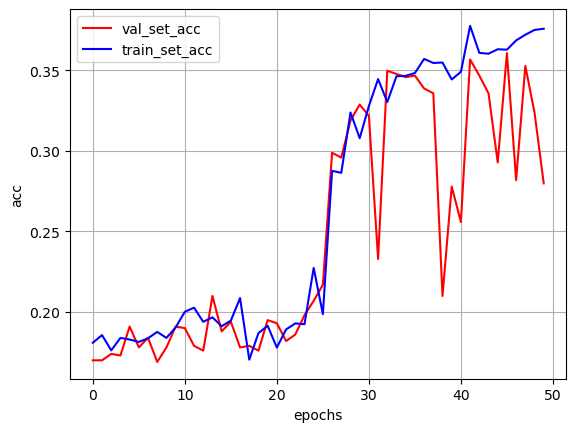

In [37]:
y_vacc = hist.history['val_acc']
y_acc = hist.history['acc']

x_len = np.arange(len(y_acc))

plt.plot(x_len,y_vacc,c='red',label='val_set_acc')
plt.plot(x_len,y_acc,c='blue',label='train_set_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()
plt.show()

In [ ]:
preds = model.predict(test_x)

submission = pd.read_csv('./open/sample_submission.csv')
submission['label'] = preds
submission.to_csv('./lgbm_submission.csv', index=False)